## parameters

In [1]:
CLUSTER_ALGO = 'KMeans'
DATA_NAME ='breast_cancer'
C_SHAPE  = 'data'
#C_SHAPE ='CIRCLE'
#C_SHAPE ='ellipse'
N_CLUSTERS_MIN = 1
N_CLUSTERS_MAX = 5

CLUSTERS_STD = 1.0
N_P_CLUSTERS = [1]

INNER_FOLDS = 10
OUTER_FOLDS = 5

## includes

In [2]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons


In [3]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

## Output registry

In [4]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../../../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments/Cluster/kmeans-kmedoids', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments/Cluster/kmeans-kmedoids


'/docker/photon_experiments/Cluster/kmeans-kmedoids'

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


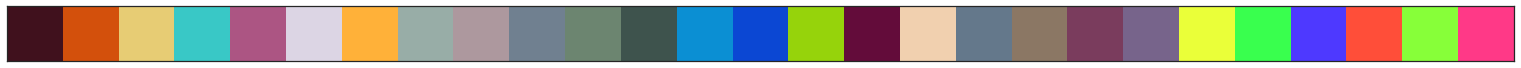

In [5]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from math import floor,ceil
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette 
PALLET = ['#40111D', '#D3500C', '#E7CC74'
                 ,'#39C8C6', '#AC5583', '#DCD5E4'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#630C3A','#F1D0AF','#64788B'                 
                 ,'#8B7764','#7A3C5D','#77648B'
                 ,'#eaff39','#39ff4e','#4e39ff'
                 ,'#ff4e39','#87ff39','#ff3987', ]
N_PALLET = len(PALLET)
sns.set_palette(PALLET)
sns.palplot(PALLET)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
from photonai.photonlogger.logger import logger
from photonai.errors import raise_PhotonaiNotImplementedError, raise_PhotonaiError
#from photonai.base.registry.registry import PhotonRegistry

## function defintions

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
DATA_DIC = {
    'iris': load_iris
    ,'breast_cancer': load_breast_cancer
    
}
DATA_DIC[DATA_NAME]

<function sklearn.datasets._base.load_breast_cancer(return_X_y=False)>

In [7]:
def yield_parameters_data(foo):
    if DATA_NAME in DATA_DIC.keys():
        data_func = DATA_DIC[DATA_NAME]
    else:
        raise_PhotonaiError('load datset unknown', data_n)

    data =  data_func()
    data_X, data_y = data.data,data.target
    yield [data_X, data_y, None]

In [8]:
#for data_X, data_y,_  in yield_parameters_data(None):
#    print(data_X)

In [9]:
def yield_parameters_ellipse(n_p_clusters):
    cluster_std = CLUSTERS_STD
    for n_p_cluster in n_p_clusters:
        for n_cluster in N_CLUSTERS:
            print('ncluster:', n_cluster)
            n_cluster_std = [cluster_std for k in range(n_cluster)]
            n_samples = [n_p_cluster for k in range(n_cluster)]
            data_X, data_y = make_blobs(n_samples=n_samples,
                                       cluster_std=n_cluster_std, random_state=0)
            transformation = [[0.6, -0.6], [-0.4, 0.8]]
            X_ellipse = np.dot(data_X, transformation)
            yield [X_ellipse, data_y, n_cluster]

In [10]:
def yield_parameters(n_p_clusters):
    cluster_std = CLUSTERS_STD
    for n_p_cluster in n_p_clusters:
        for n_cluster in N_CLUSTERS:
            n_cluster_std = [cluster_std for k in range(n_cluster)]
            n_samples = [n_p_cluster for k in range(n_cluster)]
            data_X, data_y = make_blobs(n_samples=n_samples,
                                       cluster_std=n_cluster_std, random_state=0)
            yield [data_X, data_y, n_cluster]

In [11]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [12]:
def cluster_plot(my_pipe, data_X, n_cluster, PALLET):
    y_pred= my_pipe.predict(data_X)
    data = pd.DataFrame(data_X[:, 0],columns=['x'])
    data['y'] = data_X[:, 1]
    data['labels'] = y_pred
    facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                       aspect= 1.0, height=10,
               fit_reg=False, legend=True, legend_out=True)

    customPalette = PALLET
    for i, label in enumerate( np.sort(data['labels'].unique())):
        plt.annotate(label, 
                     data.loc[data['labels']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=5, weight='bold',
                     color='white',
                     backgroundcolor=customPalette[i]) 

    plt.show()
    return y_pred

In [13]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/photon_experiments/Cluster/custom_elements'

In [14]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [15]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [16]:

registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMeans
Namespace: sklearn.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
init                                init='k-means++'                                                           
n_init                              n_init=10                                                                  
max_iter                            max_iter=300                                                               
tol                                 tol=0.0001                                                                 
precompute_distances                precompute_distances='auto'                                                
verbose                             verbose=0                                                                  
random_state                        random_state=Non

('KMeans',
 'sklearn.cluster',
 {'n_clusters': 'n_clusters',
  'init': 'init',
  'n_init': 'n_init',
  'max_iter': 'max_iter',
  'tol': 'tol',
  'precompute_distances': 'precompute_distances',
  'verbose': 'verbose',
  'random_state': 'random_state',
  'copy_x': 'copy_x',
  'n_jobs': 'n_jobs',
  'algorithm': 'algorithm'})

In [17]:
def hyper_cluster(cluster_name):
    if C_SHAPE == 'ellipse' :
        yield_f = yield_parameters_ellipse
    elif C_SHAPE == 'data' :
        yield_f = yield_parameters_data
        n_p_clusters = DATA_NAME
    else: 
        yield_f = yield_parameters
    
    n_p_clusters = N_P_CLUSTERS
    for data_X, data_y,_  in yield_f(n_p_clusters):
        print('N rows:', len(data_y))
        logger.info('N rows:', len(data_y))
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')
            
        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=OUTER_FOLDS),
                            inner_cv=KFold(n_splits=INNER_FOLDS),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(N_CLUSTERS_MIN
                                                                                      ,N_CLUSTERS_MAX),
                                                            },random_state=777)

        logger.info('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        print('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, None, PALLET)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

N rows: 569
Cluster optimization range: 1 5
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=3"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       0.6113      |      0.1433      |
|   MI   |       0.5088      |      0.2901      |
|  HCV   |       0.5137  

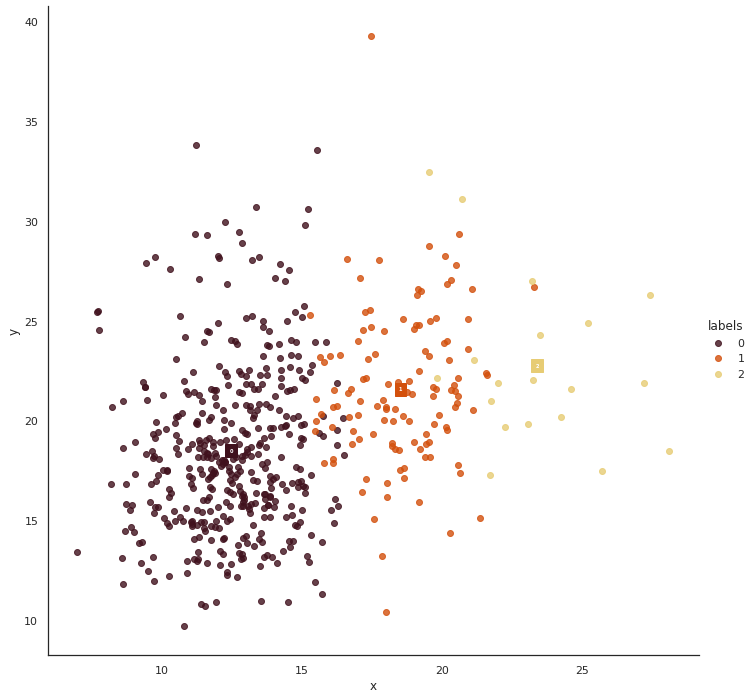

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.516092  0.056104
FM   0.792326  0.029818
HCV  0.463230  0.045008
MI   0.461700  0.028621
test 
          Mean       STD
2                      
ARI  0.519841  0.225106
FM   0.793427  0.119047
HCV  0.485619  0.120591
MI   0.474119  0.131646
            jaccard_index       0.6469400462551147
               rand_index       0.7543812965667467
            adjrand_index       0.5015630136956755
    fowlkes_mallows_index       0.7876692442806001
                 fmeasure       0.7856267114594192
             purity_index       0.8330404217926186
     classification_error       0.1669595782073814
        czekanowski_index       0.7856267114594192
               dice_index       0.7856267114594192
           sorensen_index       0.7856267114594192
    rogers_tanimoto_index       0.6056277852022237
          southwood_index       1.8323801365548864
      pearson_correlation    8.0200

In [18]:
hyper_cluster(CLUSTER_ALGO)

In [24]:
def hyper_cluster_scale_PCA(cluster_name):
    if C_SHAPE == 'ellipse' :
        yield_f = yield_parameters_ellipse
    elif C_SHAPE == 'data' :
        yield_f = yield_parameters_data
        n_p_clusters = DATA_NAME
    else: 
        yield_f = yield_parameters
    
    n_p_clusters = N_P_CLUSTERS
    for data_X, data_y,_  in yield_f(n_p_clusters):
        print('N rows:', len(data_y))
        logger.info('N rows:', len(data_y))
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')
            
        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=OUTER_FOLDS),
                            inner_cv=KFold(n_splits=INNER_FOLDS),
                            verbosity=0,
                            output_settings=settings)
        
        # ADD ELEMENTS TO YOUR PIPELINE
        # first normalize all features
        print('before scale:',X)
        my_pipe.add(PipelineElement("StandardScaler"))
        print('scale')
        logger.info('scale')
        print('after scale:',X)
        # now pca = 2d
        my_pipe.add(PipelineElement("PCA",  test_disabled=False, n_components= 2))
        print('PCA = 2D')
        logger.info('PCA = 2D')

        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(N_CLUSTERS_MIN
                                                                                      ,N_CLUSTERS_MAX),
                                                            },random_state=777)

        logger.info('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        print('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, None, PALLET)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

N rows: 569
before scale: [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
scale
after scale: [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
PCA = 2D
Cluster optimization range: 1 5
**************************************************************************************************

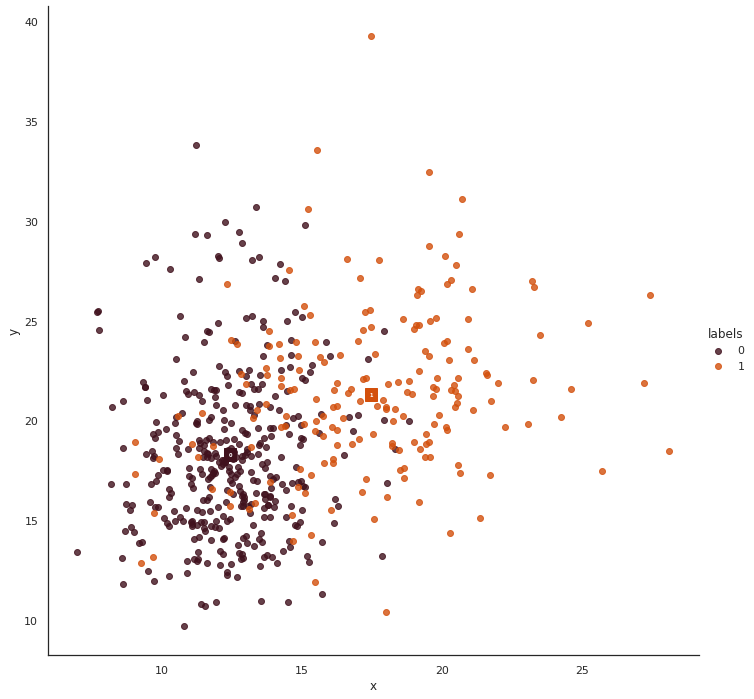

           n_clusters  k
0  KMeans__n_clusters  2
train 
          Mean       STD
2                      
ARI  0.659207  0.032351
FM   0.843917  0.020253
HCV  0.532490  0.024465
MI   0.539872  0.024584
test 
          Mean       STD
2                      
ARI  0.663695  0.114155
FM   0.848968  0.067833
HCV  0.545611  0.082947
MI   0.545510  0.087123
            jaccard_index       0.7301068795705079
               rand_index       0.8307631377014283
            adjrand_index       0.6592305570949524
    fowlkes_mallows_index        0.844168964024566
                 fmeasure       0.8440020535052193
             purity_index        0.906854130052724
     classification_error      0.09314586994727603
        czekanowski_index       0.8440020535052193
               dice_index       0.8440020535052193
           sorensen_index       0.8440020535052193
    rogers_tanimoto_index       0.7105174019815395
          southwood_index        2.705170396372678
      pearson_correlation   1.01857

In [25]:
hyper_cluster_scale_PCA(CLUSTER_ALGO)

In [21]:
def hyper_cluster_scale(cluster_name):
    if C_SHAPE == 'ellipse' :
        yield_f = yield_parameters_ellipse
    elif C_SHAPE == 'data' :
        yield_f = yield_parameters_data
        n_p_clusters = DATA_NAME
    else: 
        yield_f = yield_parameters
    
    n_p_clusters = N_P_CLUSTERS
    for data_X, data_y,_  in yield_f(n_p_clusters):
        print('N rows:', len(data_y))
        logger.info('N rows:', len(data_y))
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')
            
        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=OUTER_FOLDS),
                            inner_cv=KFold(n_splits=INNER_FOLDS),
                            verbosity=0,
                            output_settings=settings)
        
        # ADD ELEMENTS TO YOUR PIPELINE
        # first normalize all features
        my_pipe.add(PipelineElement("StandardScaler"))
        print('scale')
        logger.info('scale')
        # now pca = 2d
#        my_pipe.add(PipelineElement("PCA",  test_disabled=False, n_components= 2))
#        print('PCA = 2D')
#        logger.info('PCA = 2D')

        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(N_CLUSTERS_MIN
                                                                                      ,N_CLUSTERS_MAX),
                                                            },random_state=777)

        logger.info('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        print('Cluster optimization range:',  N_CLUSTERS_MIN, N_CLUSTERS_MAX)
        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, None, PALLET)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

N rows: 569
scale
Cluster optimization range: 1 5
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=2"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       0.7093      |      0.4636      |
|   MI   |       0.5734      |      0.3917      |
|  HCV   |       0.

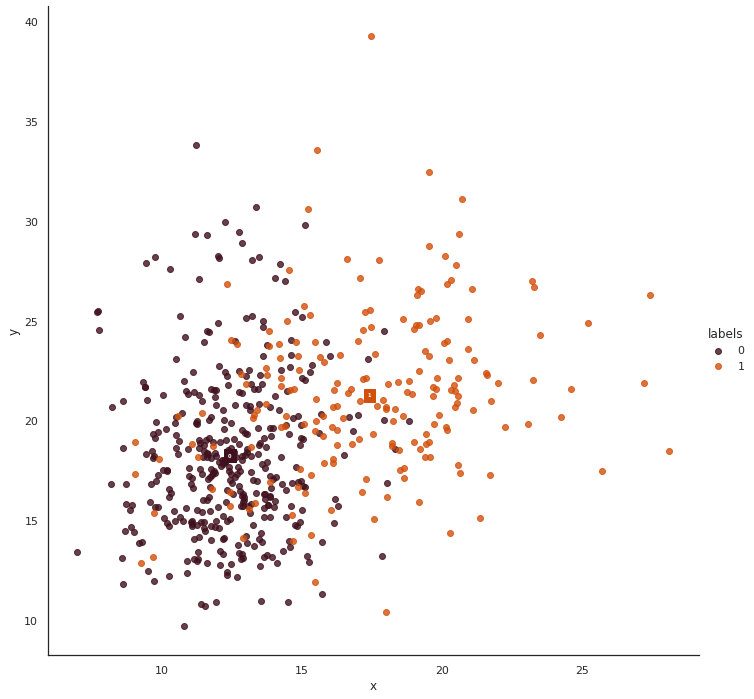

           n_clusters  k
0  KMeans__n_clusters  2
train 
          Mean       STD
2                      
ARI  0.663420  0.028314
FM   0.845903  0.017989
HCV  0.537001  0.022445
MI   0.544337  0.022811
test 
          Mean       STD
2                      
ARI  0.670690  0.122174
FM   0.851407  0.070503
HCV  0.555311  0.095202
MI   0.554206  0.098290
            jaccard_index       0.7254255361162671
               rand_index       0.8279041560434665
            adjrand_index       0.6536246043910179
    fowlkes_mallows_index       0.8409841859229374
                 fmeasure       0.8408656542189771
             purity_index       0.9050966608084358
     classification_error      0.09490333919156424
        czekanowski_index       0.8408656542189771
               dice_index       0.8408656542189771
           sorensen_index       0.8408656542189771
    rogers_tanimoto_index       0.7063450999440356
          southwood_index        2.641999280834232
      pearson_correlation   1.00891

In [22]:
hyper_cluster_scale(CLUSTER_ALGO)

In [23]:

*-+
*+-=END

SyntaxError: invalid syntax (<ipython-input-23-b9db49d6dd43>, line 1)